# Notebook for Production Degradation Chemical Reaction Network

Production-Degradation chemical reaction : $ø \xrightleftharpoons[\theta_2]{\theta_1} S$.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib.pyplot as plt

import neuralnetwork
import convert_csv
import plot
import save_load_MDN

from scipy.stats import poisson

from CRN2_production_degradation import propensities_production_degradation as propensities

## Import data

In [2]:
FILE_NAME = 'data'
CRN_NAME = 'production_degradation'
NUM_PARAMS = 2
NAME = 'Production Degradation CRN'

In [3]:
# loading data
X_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train1.csv')
X_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train2.csv')
X_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train3.csv')
y_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train1.csv')
y_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train2.csv')
y_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train3.csv')
X_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid1.csv')
X_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid2.csv')
X_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid3.csv')
y_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid1.csv')
y_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid2.csv')
y_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid3.csv')
X_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_test.csv')
y_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_test.csv')

train_data1 = [X_train1, y_train1]
valid_data1 = [X_valid1, y_valid1]
train_data2 = [X_train2, y_train2]
valid_data2 = [X_valid2, y_valid2]
train_data3 = [X_train3, y_train3]
valid_data3 = [X_valid3, y_valid3]

## Hyperparameters

In [4]:
LR = 0.001
N_ITER  = 700
BATCHSIZE = 32
N_HIDDEN = 512
MIXTURE = 'NB'

## Choosing number of components - Elbow method

We use the elbow method to choose the appropriate number of components.

Computed loss with 1 components - loss = 0.25465847210337716.
Computed loss with 2 components - loss = 0.013086967170238495.
Computed loss with 3 components - loss = 0.013052523136138916.
Computed loss with 4 components - loss = 0.01301921314249436.
Computed loss with 5 components - loss = 0.01304076270510753.
Computed loss with 6 components - loss = 0.013051247534652552.


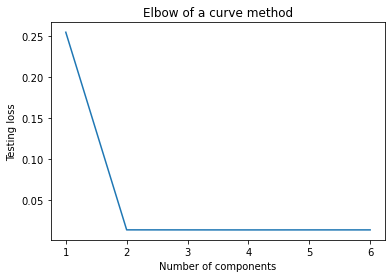

In [6]:
n_comps = np.arange(1, 7)
losses = []
for n in n_comps:
    loss = 0
    for i in range(3):
        model = neuralnetwork.NeuralNetwork(n_comps=n, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE, print_info=False)
        neuralnetwork.train_NN(model, train_data1, valid_data1, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE, print_results=False, print_info=False)
        loss += neuralnetwork.mean_loss(X_test, y_test, model, loss=neuralnetwork.loss_hellinger).detach().item()
    losses.append(loss/3)
    print(f'Computed loss with {n} components - loss = {loss/3}.')
plt.plot(n_comps, losses)
plt.xlabel('Number of components')
plt.ylabel('Testing loss')
plt.title('Elbow of a curve method')
plt.show()

In [5]:
N_COMPS = 4

## Training models

We train 3 different models to compare their accuracy.

In [6]:
model1 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)
model2 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)
model3 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE)

Mixture Density Network created.
Mixture Density Network created.
Mixture Density Network created.


In [7]:
train_losses1, valid_losses1 = neuralnetwork.train_NN(model1, train_data1, valid_data1, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses2, valid_losses2 = neuralnetwork.train_NN(model2, train_data2, valid_data2, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses3, valid_losses3 = neuralnetwork.train_NN(model3, train_data3, valid_data3, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)

Training ...: 100%|█████████▉| 699/700 [05:56<00:00,  1.96it/s]


Learning rate: 5.03550399738596e-09,
Train loss: 0.0007011619745753706,
 Valid loss: 0.0006994488066993654


Training ...: 100%|█████████▉| 699/700 [06:31<00:00,  1.79it/s]


Learning rate: 5.03550399738596e-09,
Train loss: 0.0007012145943008363,
 Valid loss: 0.0007158973603509367


Training ...: 100%|█████████▉| 699/700 [07:21<00:00,  1.58it/s]

Learning rate: 5.03550399738596e-09,
Train loss: 0.0007014575530774891,
 Valid loss: 0.0006819514674134552


In [8]:
for i, model in enumerate([model1, model2, model3]):
    save_load_MDN.save_MDN_model(model, f'CRN2_model{i+1}_comps4.pt')

In [6]:
model1 = save_load_MDN.load_MDN_model('saved_models_4comps/CRN2_model1_comps4.pt')
model2 = save_load_MDN.load_MDN_model('saved_models_4comps/CRN2_model2_comps4.pt')
model3 = save_load_MDN.load_MDN_model('saved_models_4comps/CRN2_model3_comps4.pt')

Mixture Density Network created.
Mixture Density Network created.
Mixture Density Network created.


In [9]:
# Compute losses

print("Training dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_train1, y_train1, model1, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_train1, y_train1, model1, loss=neuralnetwork.loss_hellinger)}')

print("\nValidation dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_valid1, y_valid1, model1, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_valid1, y_valid1, model1, loss=neuralnetwork.loss_hellinger)}')

print("\nTest dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_test, y_test, model1, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_test, y_test, model1, loss=neuralnetwork.loss_hellinger)}')


Training dataset
KLD : 0.0007011619745753706
Hellinger : 0.01297704316675663

Validation dataset
KLD : 0.0006994488066993654
Hellinger : 0.013042639940977097

Test dataset
KLD : 0.000713897927198559
Hellinger : 0.013102171942591667


## Distributions plot

To compare predicted distributions to the theoretical ones. Given an initial condition of 0 $S$, the population of $S$ at any later time is a random integer sampled from a Poisson distribution:

$$f(x, t, \theta_1, \theta_2) = \frac{\lambda(t, \theta_1, \theta_2)^x e^{-\lambda(t, \theta_1, \theta_2)}}{x!} \text{ where } \lambda(t, \theta_1, \theta_2) = \frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t})$$

In [7]:
def production_degradation_distribution(x, params):
    t, theta1, theta2 = params
    lambd = theta1*(1-np.exp(-theta2*t))/theta2
    return poisson.pmf(x, lambd)

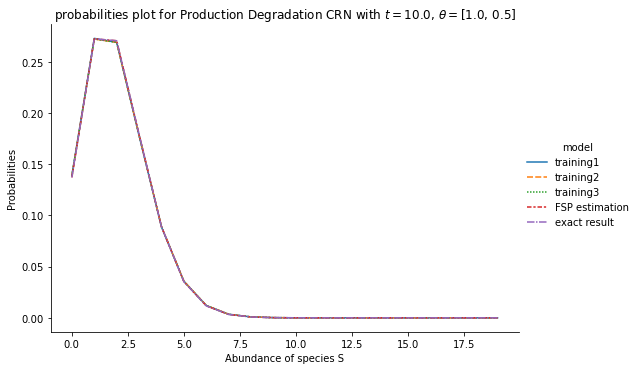

In [11]:
plot.plot_model(to_pred=torch.tensor([10., 1., 0.5]), 
                models=[model1, model2, model3], 
                up_bound = 20, 
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_distribution),
                plot_fsp_result=(True, np.expand_dims(propensities.stoich_mat, axis=0), propensities.propensities, 100, None, 0),
                save=(False, "1distribution.png"),
                crn_name=NAME)

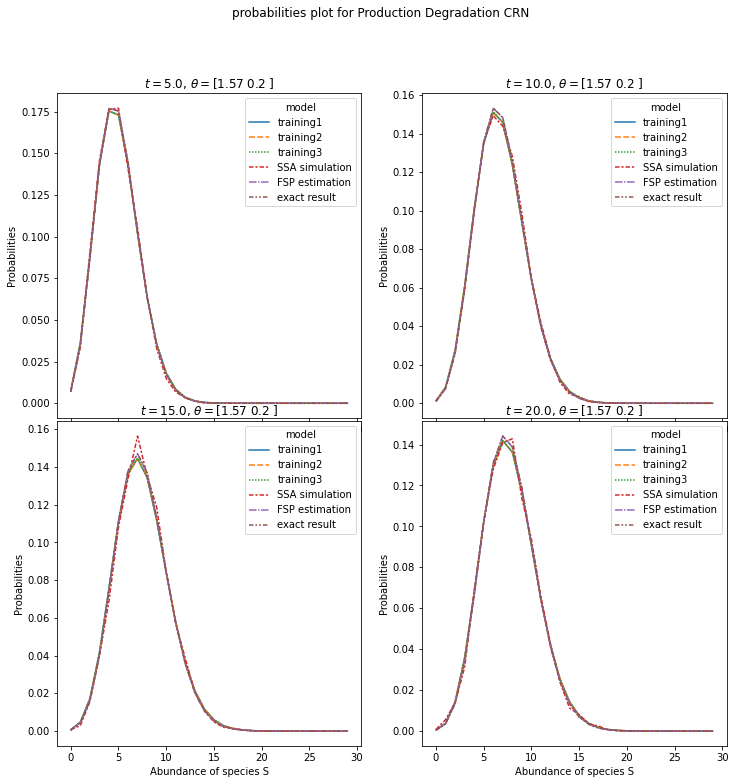

In [9]:
plot.multiple_plots(to_pred=[X_test[996+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = 4*[30],
                    n_comps=N_COMPS,
                    plot_exact_result=(True, production_degradation_distribution), 
                    plot_test_result = (True, [y_test[996+k,:] for k in range(4)]),
                    plot_fsp_result=(True, np.expand_dims(propensities.stoich_mat, axis=0), propensities.propensities, 100, None, 0),
                    save=(False, "4distributions.png"),
                    crn_name=NAME)

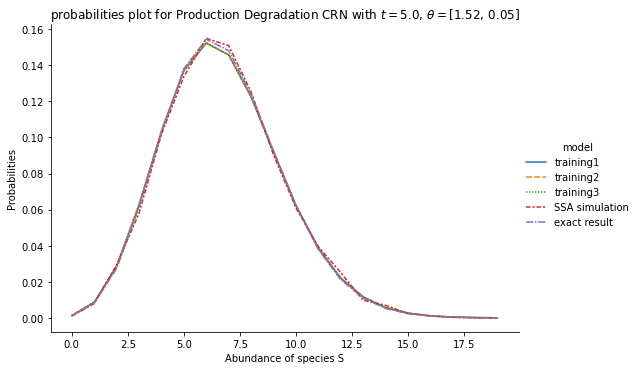

In [10]:
index = 100
plot.plot_model(to_pred=X_test[index,:], 
                models=[model1, model2, model3], 
                up_bound = 20, 
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_distribution),
                plot_test_result=(True, y_test[index, :]),
                crn_name=NAME)

We can check the accuracy for higher times than those of the training:

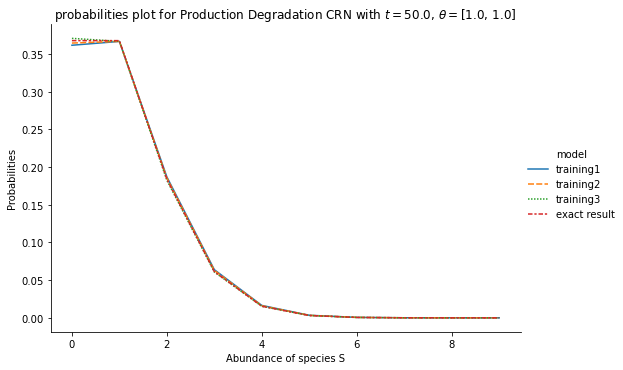

In [22]:
plot.plot_model(to_pred=torch.tensor([50., 1., 1.]), 
        models=[model1, model2, model3], 
        up_bound = 10, 
        n_comps=N_COMPS,
        plot_exact_result=(True, production_degradation_distribution),
        save=(False, "t50k1g1.png"),
        crn_name=NAME)

We can also check the accuracy for parameters outside the bounds of the training.

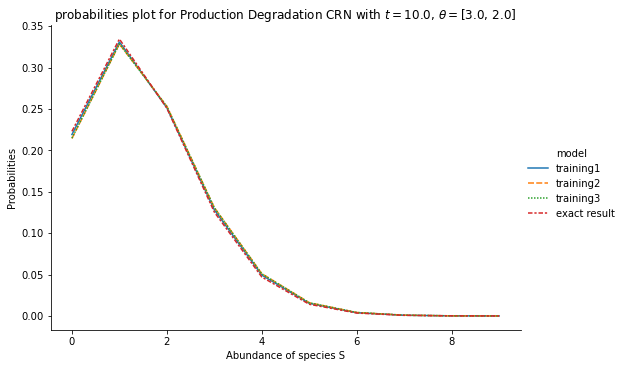

In [15]:
plot.plot_model(to_pred=torch.tensor([10., 3., 2.]), 
                models=[model1, model2, model3], 
                up_bound = 10, 
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_distribution),
                save=(False, "t10k3g2.png"),
                crn_name=NAME)

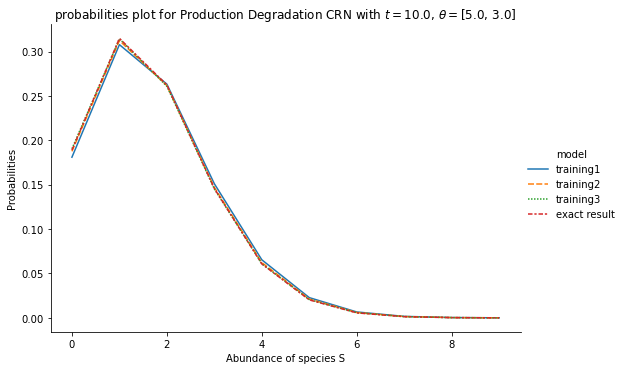

In [16]:
plot.plot_model(to_pred=torch.tensor([10., 5., 3.]), 
                models=[model1, model2, model3], 
                up_bound = 10, 
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_distribution),
                save=(False, "t10k5g3.png"),
                crn_name=NAME)

## Sentivities plot

To compute sensitivities and compare them to the theoretical ones. 

### With respect to $\theta_1$

$$\nabla_{\theta_1} f(x,t,\theta_1, \theta_2) = \frac{1-e^{-\theta_2 t}}{\theta_2} \times e^{-\lambda} (\frac{\lambda^{x-1}}{(x-1)!} - \frac{\lambda^x}{x!})

In [8]:
def production_degradation_stv_1(x, params):
    t, theta1, theta2 = params[0], params[1], params[2]
    lambd = theta1*(1-np.exp(-theta2*t))/theta2
    dlambd = (1-np.exp(-theta2*t))/theta2
    return dlambd * (poisson.pmf(x-1, lambd) - poisson.pmf(x, lambd))

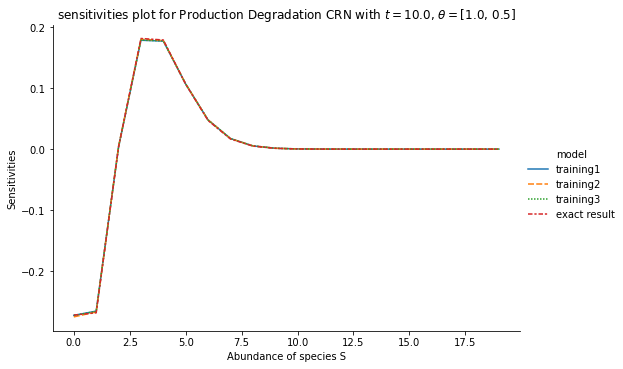

In [18]:
plot.plot_model(to_pred=torch.tensor([10., 1., 0.5]), 
                models=[model1, model2, model3], 
                up_bound=20, 
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_stv_1),
                plot=('sensitivities', 0), 
                index_names = ('Sensitivities', 'Abundance of species S'), 
                save=(False, "sensitivities_1distr.png"),
                crn_name=NAME)

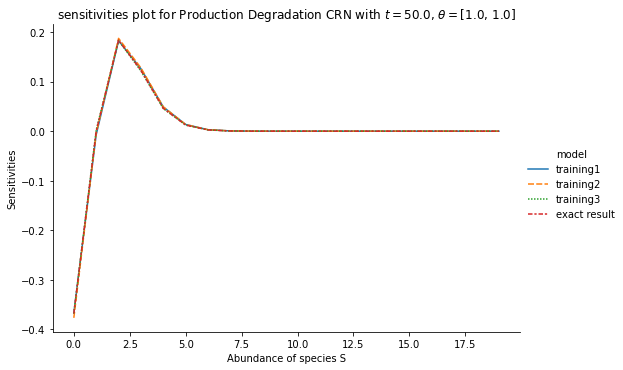

In [23]:
plot.plot_model(to_pred=torch.tensor([50., 1., 1.]), 
                models=[model1, model2, model3], 
                up_bound=20,
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_stv_1),
                plot=('sensitivities', 0), 
                confidence_interval=False,
                index_names = ('Sensitivities', 'Abundance of species S'),
                crn_name=NAME)

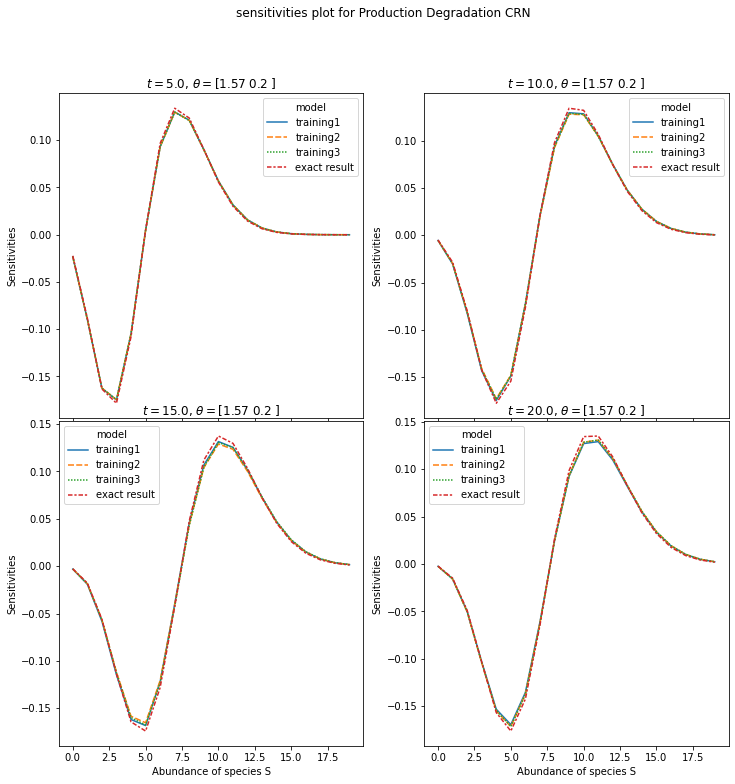

In [24]:
plot.multiple_plots(to_pred=[X_test[996+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [20]*5,
                    n_comps=N_COMPS,
                    plot_exact_result=(True, production_degradation_stv_1),
                    plot=('sensitivities', 0), 
                    index_names = ('Sensitivities', 'Abundance of species S'),
                    save=(False, 'sensitivities_kr_median.png'),
                    crn_name=NAME)

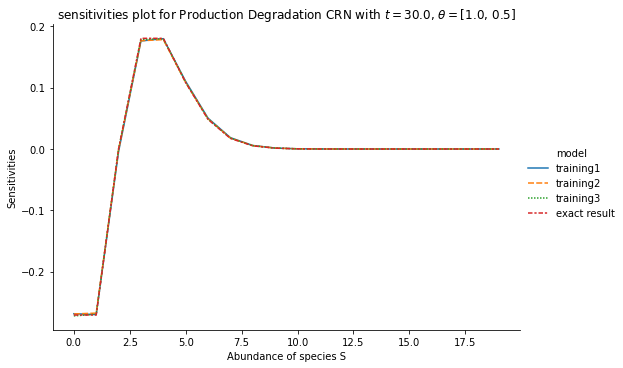

In [25]:
plot.plot_model(to_pred=torch.tensor([30., 1., 0.5]), 
                models=[model1, model2, model3], 
                up_bound=20, 
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_stv_1),
                plot=('sensitivities', 0), 
                index_names = ('Sensitivities', 'Abundance of species S'),
                save=(False, "sensitivities_t30k1g5.png"),
                crn_name=NAME)

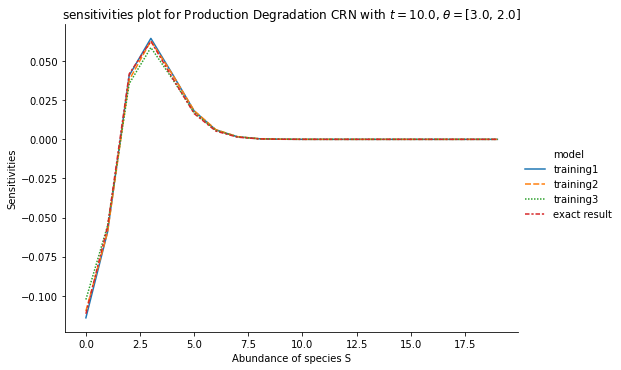

In [26]:
plot.plot_model(to_pred=torch.tensor([10., 3., 2.]), 
                models=[model1, model2, model3], 
                up_bound=20, 
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_stv_1),
                plot=('sensitivities', 0), 
                index_names = ('Sensitivities', 'Abundance of species S'), 
                save=(False, "sensitivities_t10k3g2.png"),
                crn_name=NAME)

### With respect to $\theta_2$

\begin{align}
\nabla_{\theta_2} f(x, t, \theta_1, \theta_2) &= \nabla_{\theta_2} \lambda(t, \theta_1, \theta_2) e^{-\lambda} (\frac{\lambda^{x-1}}{(x-1)!} - \frac{\lambda^x}{x!}) \\ \text{ where } \nabla_{\theta_2} \lambda(t, \theta_1, \theta_2) &= \frac{\theta_1}{\theta_2} (1- e^{-\theta_2 t}) (te^{-\theta_2 t}-\frac{1}{\theta_2}) \\ &= \lambda(t, \theta_1, \theta_2)(te^{-\theta_2 t}-\frac{1}{\theta_2})
\end{align}

In [9]:
def production_degradation_stv_2(x, params):
    t, theta1, theta2 = params[0], params[1], params[2]
    lambd = theta1*(1-np.exp(-theta2*t))/theta2
    dlambd = lambd * (t*np.exp(-theta2*t) - 1/theta2)
    return dlambd * (poisson.pmf(x-1, lambd) - poisson.pmf(x, lambd))

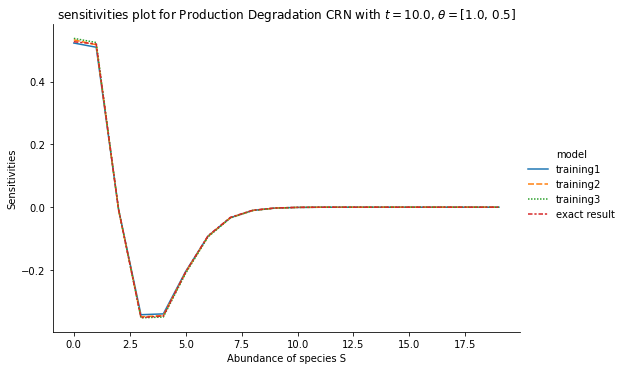

In [28]:
plot.plot_model(to_pred=torch.tensor([10., 1., 0.5]), 
                models=[model1, model2, model3], 
                up_bound=20, 
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_stv_2),
                plot=('sensitivities', 1),
                index_names = ('Sensitivities', 'Abundance of species S'),
                save=(False, "sensitivities_gamma_t10k1g5.png"),
                crn_name=NAME)

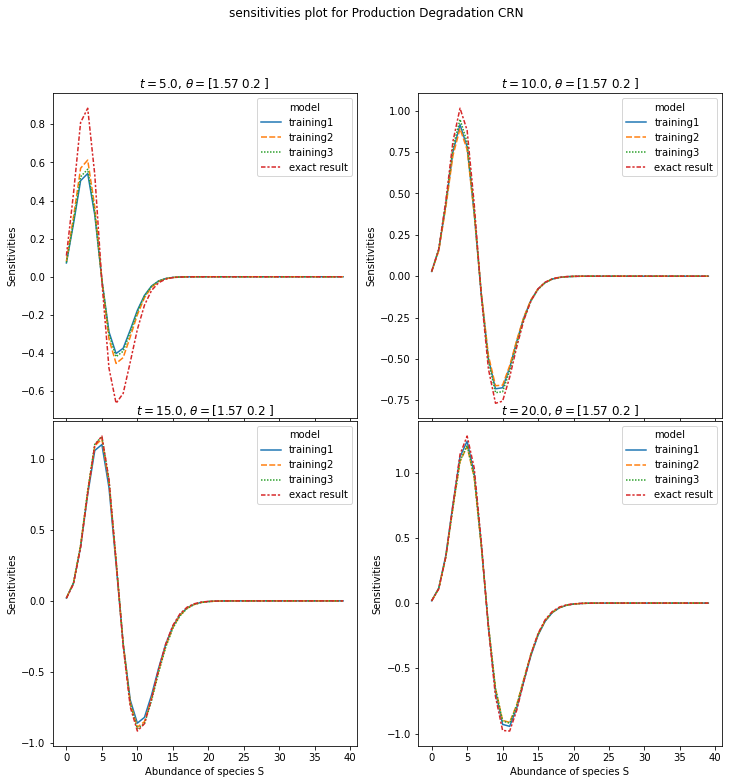

In [29]:
plot.multiple_plots(to_pred=[X_test[996+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [40]*6, 
                    n_comps=N_COMPS,
                    plot_exact_result=(True, production_degradation_stv_2),
                    plot=('sensitivities', 1),
                    index_names = ('Sensitivities', 'Abundance of species S'),
                    save=(False, "sensitivities_4distr_gamma.png"),
                    crn_name=NAME)

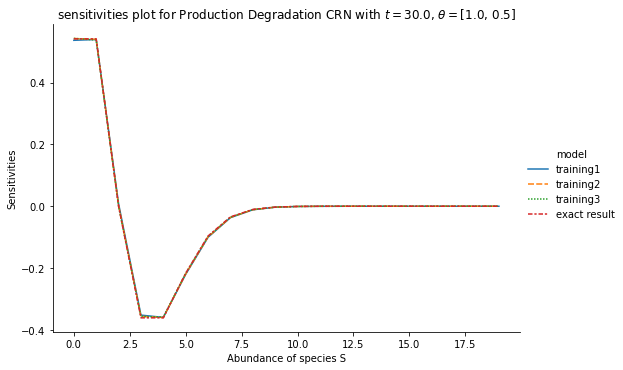

In [30]:
plot.plot_model(to_pred=torch.tensor([30., 1., 0.5]), 
            models=[model1, model2, model3], 
            up_bound=20, 
            n_comps=N_COMPS,
            plot_exact_result=(True, production_degradation_stv_2),
            plot=('sensitivities', 1),
            index_names = ('Sensitivities', 'Abundance of species S'),
            save=(False, "sensitivities_gamma_t30k1g5.png"),
            crn_name=NAME)

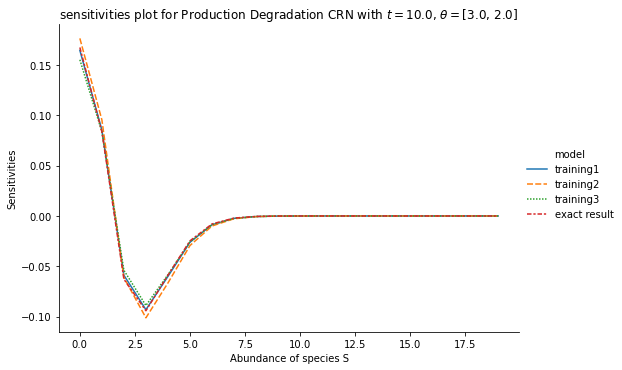

In [31]:
plot.plot_model(to_pred=torch.tensor([10., 3., 2]), 
                models=[model1, model2, model3], 
                up_bound=20, 
                n_comps=N_COMPS,
                plot_exact_result=(True, production_degradation_stv_2),
                plot=('sensitivities', 1),
                index_names = ('Sensitivities', 'Abundance of species S'),
                save=(False, "sensitivities_gamma_t10k3g2.png"),
                crn_name=NAME)

## Fisher information

The exact solution for the Fisher information for Poisson fluctuations is:
$$I_{Poisson(\lambda)} = \frac{1}{\lambda}.$$

\begin{align}
p(x, \theta_1, \theta_2 ) &= \frac{(\frac{kr}{\theta_2}(1-e^{-\theta_2 t}))^x e^{-\frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t})}}{x!} \\
\log p(x, \theta_1, \theta_2) &= x (\log(\theta_1)-\log(\theta_2) + \log(1-e^{-\theta_2 t}))-\frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t}) - \log(x!)\\
\frac{\partial}{\partial \theta_1} \log p(x,\theta_1, \theta_2) &= \frac{x}{\theta_1} - \frac{1}{\theta_2}(1-e^{-\theta_2 t}) \\
\frac{\partial^2}{\partial \theta_1^2} \log p(x, \theta_1, \theta_2) &= -\frac{x}{\theta_1^2}
\end{align}

\begin{align}
-\mathbb{E}[\frac{\partial^2}{\partial \theta_1^2} \log p(X)]
    &=-\sum_x \frac{\partial^2}{\partial \theta_1^2} \log p(x, \theta_1, \theta_2) p(x) \\
    &=- \sum_x -\frac{x}{\theta_1^2}\frac{(\frac{kr}{\theta_2}(1-e^{-\theta_2 t}))^x e^{-\frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t})}}{x!} \\
    &= \frac{e^{-\frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t})}}{\theta_1^2} \sum_x \frac{x[\frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t})]^x}{x!} \\
    &= \frac{e^{-\frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t})}}{\theta_1^2}[\sum_{x \leq 1} \frac{[\frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t})]^{x-1}}{(x-1)!}] \times \frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t}) \\
    &= \frac{e^{-\frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t})}}{\theta_1^2} \times e^{\frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t})} \times \frac{\theta_1}{\theta_2}(1-e^{-\theta_2 t}) \\
    &= \frac{\lambda}{\theta_1^2}


\end{align}

\begin{align*}
\frac{\partial}{\partial \gamma} \log p(x,k_r, \gamma) 
&= x[-\frac{1}{\gamma} + \frac{te^{-\gamma t}}{1-e^{-\gamma t}}]+\frac{k_r}{\gamma^2}(1-e^{-\gamma t})-\frac{k_r}{\gamma} te^{-\gamma t}\\
&= x[-\frac{1}{\gamma} + \frac{t}{e^{\gamma t}-1}]+\frac{k_r}{\gamma^2}(1-e^{-\gamma t})-\frac{k_r}{\gamma} te^{-\gamma t}
\end{align*}

\begin{align*}
\frac{\partial^2}{\partial \gamma^2} \log p(x,k_r, \gamma) 
    &=\frac{x}{\gamma^2} + xt \frac{te^{\gamma t}}{(e^{\gamma t} - 1)^2} -2\frac{k_r}{\gamma^3}(1-e^{-\gamma t}) + \frac{k_r}{\gamma^2}\times te^{-\gamma t} + \frac{k_r}{\gamma^2} te^{-\gamma t} + \frac{k_r}{\gamma}t^2 e^{-\gamma t}\\
    &=\frac{x}{\gamma^2} + xt \frac{te^{\gamma t}}{(e^{\gamma t} - 1)^2} -2\frac{k_r}{\gamma^3}(1-e^{-\gamma t}) + 2\frac{k_r}{\gamma^2}\times te^{-\gamma t} + \frac{k_r}{\gamma}t^2 e^{-\gamma t}    
\end{align*}

\begin{align*}
\mathbb{E}[\frac{\partial^2}{\partial \gamma^2} \log p(X,k_r, \gamma)]
    &= \sum_x \frac{\partial^2}{\partial \gamma^2} \log p(x,k_r, \gamma) p(x, k_r, \gamma)\\
    &= \sum_x [\frac{x}{\gamma^2} + xt \frac{te^{\gamma t}}{(e^{\gamma t} - 1)^2} -2\frac{\lambda}{\gamma^2} + 2\frac{k_r}{\gamma^2}\times te^{-\gamma t} + \frac{k_r}{\gamma}t^2 e^{-\gamma t}] \times \frac{\lambda^x e^{-\lambda}}{x!} \\
\end{align*}

\begin{align}
Var[\frac{\partial}{\partial \gamma} \log p] 
    &= [\frac{-1}{\gamma} + \frac{t}{e^{\gamma t}-1}]^2 \lambda
\end{align}

In [11]:
def exact_fi_1(t, params):
    theta1, theta2 = params[0], params[1]
    lambd = -theta1/theta2*(1-np.exp(-theta2*t))
    return -lambd/theta1**2

In [12]:
def exact_fi_2(t, params):
    theta1, theta2 = params[0], params[1]
    lambd = -theta1/theta2*(1-np.exp(-theta2*t))
    return - lambd*(-1/theta2 + t/(np.exp(theta2*t)-1))**2

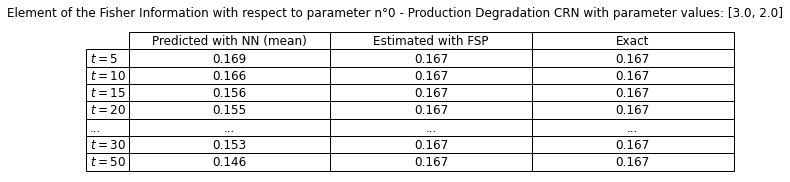

In [13]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30, 50], 
            params=[3., 2.], 
            ind_param=0,
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_exact=(True, exact_fi_1),
            plot_fsp=(True, np.expand_dims(propensities.stoich_mat, axis=0), np.array([propensities.lambda1, propensities.lambda2]), 50, None, 0),
            crn_name=NAME,
            out_of_bounds_index=4)

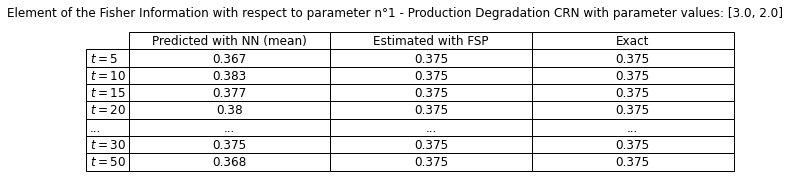

In [14]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30, 50], 
            params=[3., 2.], 
            ind_param=1, 
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_exact=(True, exact_fi_2),
            plot_fsp=(True, np.expand_dims(propensities.stoich_mat, axis=0), np.array([propensities.lambda1, propensities.lambda2]), 50, None, 0),
            crn_name=NAME,
            out_of_bounds_index=4) 

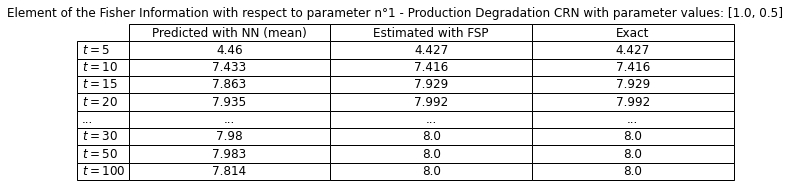

In [15]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30, 50, 100], 
            params=[1., 0.5], 
            ind_param=1, 
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_exact=(True, exact_fi_2),
            plot_fsp=(True, np.expand_dims(propensities.stoich_mat, axis=0), np.array([propensities.lambda1, propensities.lambda2]), 50, None, 0),
            crn_name=NAME,
            out_of_bounds_index=4) 

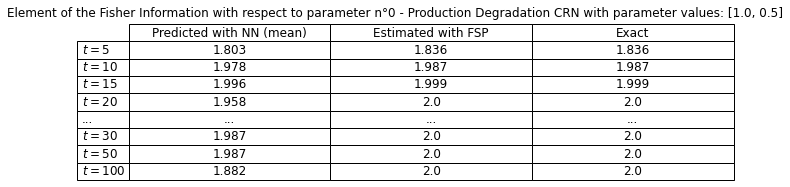

In [16]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30, 50, 100], 
            params=[1., 0.5], 
            ind_param=0, 
            models = (True, [model1, model2, model3], N_COMPS), 
            plot_exact=(True, exact_fi_1),
            plot_fsp=(True, np.expand_dims(propensities.stoich_mat, axis=0), np.array([propensities.lambda1, propensities.lambda2]), 50, None, 0),
            crn_name=NAME,
            out_of_bounds_index=4) 